In [1]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 다운로드 함수
import gdown, zipfile, os, glob, shutil
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/전력수요예측/'

# 불러오기
X = np.load(path+'X_train_24.npy')
Y = np.load(path+'Y_train_24.npy')

print(X.shape)
print(Y.shape)

(7585926, 24, 13)
(7585926, 1)


In [4]:
# train_test_split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

del X, Y

## 모델링

In [5]:
from sklearn.metrics import *

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# 메모리 정리
clear_session()

# 모델 선언
model = Sequential()
model.add(Input(shape=(24,13)))
model.add(Conv1D(64, 5, activation='relu', padding = 'same'))
model.add(Conv1D(16, 5, activation='relu', padding = 'same'))
model.add(Conv1D(8, 5, activation='relu', padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 16)            5136      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 8)             648       
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 128)               24704     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [7]:
model.compile(loss='mae', optimizer=Adam(0.001), metrics=['mse'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1,restore_best_weights=True)

cp_path = path+'모델 자동저장/CONV2_{epoch:03d}.h5'
mcp = ModelCheckpoint(cp_path, monitor='val_loss', verbose = 1, save_best_only=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=10,
                                 verbose=1,
                                 factor=0.1,
                                 min_lr=0.000001)

history = model.fit(x_train, y_train,
                    batch_size=50000, validation_split=0.2,
                    callbacks=[es, mcp, lr_reduction], epochs=1000).history

Epoch 1/1000
98/98 [==============================] - ETA: 0s - loss: 0.0363 - mse: 0.0035
Epoch 1: val_loss improved from inf to 0.02261, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/CONV2_001.h5
98/98 [==============================] - 23s 159ms/step - loss: 0.0363 - mse: 0.0035 - val_loss: 0.0226 - val_mse: 0.0015 - lr: 0.0010
Epoch 2/1000
97/98 [============================>.] - ETA: 0s - loss: 0.0183 - mse: 8.4680e-04
Epoch 2: val_loss improved from 0.02261 to 0.01584, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/CONV2_002.h5
98/98 [==============================] - 10s 105ms/step - loss: 0.0183 - mse: 8.4658e-04 - val_loss: 0.0158 - val_mse: 5.2756e-04 - lr: 0.0010
Epoch 3/1000
97/98 [============================>.] - ETA: 0s - loss: 0.0153 - mse: 5.4086e-04
Epoch 3: val_loss improved from 0.01584 to 0.01372, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/CONV2_003.h5
98/98 [==============================] - 10s 106ms/step - los

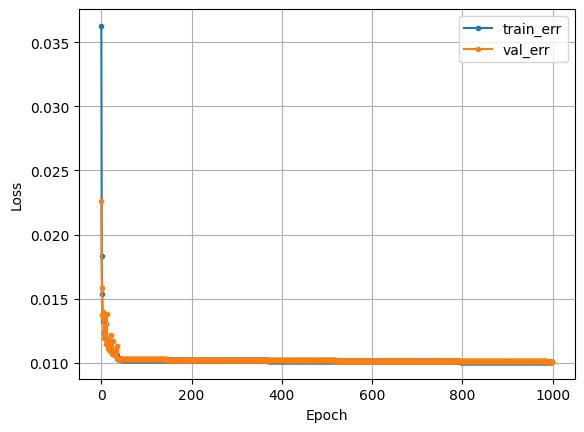

In [8]:
dl_history_plot(history)